In [1]:
import torch
import numpy as np 
import os
import pandas as pd
import pickle
from datasets import MeltomeUnirepDataset
import models
from torch.utils.data import DataLoader
import time
import datetime
import torch.optim as optim
import torch.nn as nn
import random
import sys

In [2]:
# Housekeeping
seed_val = 2020

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [3]:
# set unirep vector directory, and the path to the dictionary that contains the labels
URdir = "../datasets/Meltome_Vecs"
dict_path = "../datasets/protID2MT.p"
# creating a indexed dataset, returns a {"vec": tensor, "meltingTemp": num} for dataset[i]
MUData = MeltomeUnirepDataset(URdir=URdir, dictPath=dict_path, data="train")
MUVal = MeltomeUnirepDataset(URdir=URdir, dictPath=dict_path, data="val")
# creating a dataloader
train_loader = DataLoader(MUData, batch_size = 10, shuffle=True, num_workers=1)
val_loader = DataLoader(MUVal, batch_size = 10, num_workers=1)

In [4]:
# determining if able to use gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# creating a classifier
#model = models.SimpleNN(h_units=512)
model = models.ConvNN()
model.to(device)

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(0, 1))
  (conv2): Conv1d(16, 8, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=105, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (bn1d1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1d2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1d3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [27]:
# training the classifier

def train_model(model, loader, epochs=1, loss_fn=None, optimizer=None):
    # define default loss functions and optimizer
    if not loss_fn:
        loss_fn = nn.MSELoss()
    if not optimizer:
        optimizer = optim.Adam(model.parameters(), lr=0.0003)
    
    model.train()
    
    loss_values = []

    for epoch in range(epochs):
        if epochs > 1:
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
            print('Training...')
        t0 = time.time()
        running_loss = 0.0
        for i, data in enumerate(loader):
            inputs, label = data["vec"].to(device), data["meltingTemp"].to(device)

            optimizer.zero_grad()

            output = torch.flatten(model(inputs))

            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()

            # keeping track of a running loss
            running_loss += loss.item()
            if not i == 0:
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                sys.stdout.write("\r" + '  Batch {:>5,}  of  {:>5,}.    Loss: {:>5.4f}     Elapsed: {:}.'.format(i, len(loader), loss.item(), elapsed))
                
        #calculating the average training loss
        avg_train_loss = running_loss / len(loader)
        loss_values.append(avg_train_loss)
        #printing updates
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    return loss_values

def eval_model(model, loader, loss_fn=None):

    if not loss_fn:
        loss_fn = nn.MSELoss()

    print("Running Validation...")

    t0 = time.time()
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in loader:
        inputs, labels = batch["vec"].to(device), batch["meltingTemp"].to(device)

        with torch.no_grad():
            #forward pass without gradient calculations for speeeeeed

            outputs = torch.flatten(model(inputs))

        # calculating validation loss
        tmp_eval_accuracy = loss_fn(outputs, labels)

        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1

    print("  Loss: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    return float(eval_accuracy/nb_eval_steps)

In [28]:
train_loss = []
val_loss = []
epochs = 10
for i in range(epochs): 
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))
    print('Training...')
    train_loss.extend(train_model(model, train_loader, epochs=1))
    val_loss.append(eval_model(model, val_loader))


======== Epoch 1 / 10 ========
Training...


NameError: name 'dataloader' is not defined

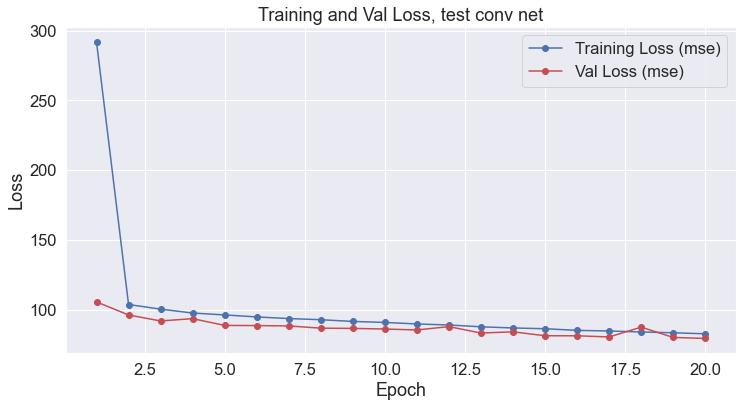

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
def plot_loss_vals(loss_vals, lv2, title="Training loss"):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot([i + 1 for i in range(len(loss_vals))], loss_vals, 'b-o', label="Training Loss (mse)")
    plt.plot([i + 1 for i in range(len(lv2))], lv2, 'r-o', label="Val Loss (mse)")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
plot_loss_vals(train_loss, val_loss, title="Training and Val Loss, test conv net")

In [ ]:
def savemodel(model, modelname, iter=0):
    

In [9]:
with open("temp.txt", "a") as f:
    f.write("conv\n")
    f.write(str(train_loss) + "\n")
    f.write(str(val_loss) + "\n")